In [1]:
import sacc
import numpy as np
from matplotlib import pyplot as plt

# You need to download the data and uncompress it from https://zenodo.org/record/5834378#.YeBonljMJUQ to the folder below
root = './DESI_LRGs_MWhite/'

In [2]:
all_ells = np.arange(2048 * 3)

s = sacc.Sacc()
s.add_tracer('Map', 'PLAcv', quantity='cmb_convergence', spin=0, ell=all_ells, beam=np.ones_like(all_ells))
sn = np.array([4.019633e-06, 2.242553e-06, 2.069106e-06, 2.263650e-06])
for i in range(1, 5):
    z, nz = np.loadtxt(root + f'lrg_s0{i}_dndz.txt', unpack=True)
    trn = f'DESI_LRG__{i-1}'
    s.add_tracer('NZ', trn, quantity='galaxy_density', z=z, nz=nz)
    
    ell, cl, clx = np.loadtxt(root + f'lrg_s0{i}_cls.txt', unpack=True)    
    wins = np.loadtxt(root +  f'lrg_s0{i}_wla.txt')
    wins = sacc.BandpowerWindow(all_ells, wins.T)
    s.add_ell_cl('cl_00', trn, trn, ell, cl - sn[i-1], window=wins)

    wins = np.loadtxt(root +  f'lrg_s0{i}_wlx.txt')
    wins = sacc.BandpowerWindow(all_ells, wins.T)
    s.add_ell_cl('cl_00', trn, 'PLAcv', ell, clx, window=wins)

size = s.mean.size
cov = np.zeros((size, size))
for i in range(1, 5):
    cov_ix = np.loadtxt(root +  f'lrg_s0{i}_cov.txt')
    trn = f'DESI_LRG__{i-1}'
    ix1 = s.indices(tracers=(trn, trn))
    ix2 = s.indices(tracers=(trn, 'PLAcv'))
    ix = np.concatenate([ix1, ix2])
    cov[np.ix_(ix, ix)] = cov_ix
s.add_covariance(cov)

s.save_fits("cls_DESI_LRGs_MWhite.sacc", overwrite=True)

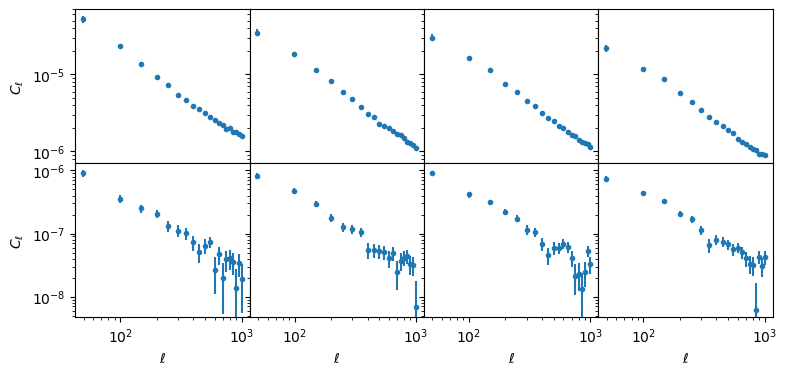

In [3]:
f, ax = plt.subplots(2, 4, figsize=(9, 4), sharex=True, sharey='row', gridspec_kw={'hspace':0, 'wspace':0})
for i in range(4):
    trn = f'DESI_LRG__{i}'
    ell, cl, cov = s.get_ell_cl('cl_00', trn, trn, return_cov=True)
    err = np.sqrt(np.diag(cov))
    ax[0, i].errorbar(ell, cl, yerr=err, fmt='.')
    
    ell, cl, cov = s.get_ell_cl('cl_00', trn, 'PLAcv', return_cov=True)
    err = np.sqrt(np.diag(cov))
    ax[1, i].errorbar(ell, cl, yerr=err, fmt='.')

    ax[1, i].set_xlabel('$\ell$')
ax[0, 0].set_ylabel('$C_\ell$')
ax[1, 0].set_ylabel('$C_\ell$')
ax[0, 0].set_yscale('log')
ax[1, 0].set_yscale('log')
ax[0, 0].set_xscale('log')
plt.show()
plt.close()